In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import HTML, IFrame
#import ROOT
#from ROOT import RooFit
%matplotlib inline
from ipywidgets import interact, interactive, fixed

In [2]:
HTML('<link rel="stylesheet" href="custom.css" type="text/css">')

In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
          'theme': 'sans',
          'transition': 'zoom',
})

{u'start_slideshow_at': 3, u'theme': 'sans', u'transition': 'zoom'}

# Lecture 1

<p style="text-align: center;"><i class="icon-user icon-2x"> [ruggero.turra@mi.infn.it](mailto:ruggero.turra@mi.infn.it)</i></p>
<br/>

## Content of the day

   * Basic notion you should already have
   * Introduction to inferential statistics
   * Counting experiments
   * p-values, type-1, type-2 errors

## Intro to the lectures
   * This is not a course on [RooFit](https://root.cern.ch/roofit) / [RooStats](https://twiki.cern.ch/twiki/bin/view/RooStats/WebTopicList) / ...
   * This is not a course of python / [numpy](http://www.numpy.org/) / [matplotlib](http://matplotlib.org/) / ...
   * I have just collected some examples that can be interesting for your studies with the minimal-needed theory

<small>
These lectures are available on https://github.com/wiso/StatisticsLectures as [jupyter](http://jupyter.org/) (previous [ipython](http://ipython.org/) notebook) notebook. They can be shown as interactive slides using [RISE](https://github.com/damianavila/RISE). It works also with a simple `jupyter nbconvert --to slides file.ipynb --post serve`, but style is not optimized. </small>

## Resources

* [Kyle Cranmer](http://orcid.org/0000-0002-5769-7094) [lectures](https://indico.cern.ch/event/117033/other-view?view=standard) and [proceedings](https://cds.cern.ch/record/2004587/files/arXiv:1503.07622.pdf) at 2011 ESHEP (see page 3 for many books)
* Kyle Cranmer [lectures](https://indico.cern.ch/event/243641/) for summer students in 2013

In [4]:
HTML('''<iframe width="49%" height="300" src="https://indico.cern.ch/event/117033/contribution/19/attachments/55755/80228/Cranmer_L1.pdf" frameborder="0" allowfullscreen></iframe>
     <iframe width="49%" height="300" src="https://indico.cern.ch/event/243641/" frameborder="0" allowfullscreen></iframe>''')

[Luca Lista](http://people.na.infn.it/~lista/Statistics/) with RooStats examples

In [5]:
IFrame('http://people.na.infn.it/~lista/Statistics/', width=900, height=400)

LHC discovery related:

   * Eilam Gross [LHC Statistics for Pedestrians](http://cds.cern.ch/record/1099994/files/p205.pdf)
   * [Asymptotic formulae for likelihood-based tests of new physics](http://arxiv.org/pdf/1007.1727v3.pdf)
   * [Procedure for the LHC Higgs boson search
combination in Summer 2011](https://cds.cern.ch/record/1379837/files/NOTE2011_005.pdf)

   
Others:
   * Gerhard Bohm, Günter Zech ["Introduction to Statistics and Data
Analysis for Physicists"](http://www-library.desy.de/preparch/books/vstatmp_engl.pdf)
   * Roger Barlow ["Systematic Errors: Facts and Fictions"](http://arxiv.org/pdf/hep-ex/0207026v1.pdf)
   * Grégory Schott [RooStats for Searches](http://indico.cern.ch/event/107747/contribution/25/attachments/24332/35016/schott_2011.01.17__RooStats_talk.pdf)


   * Statistics seems easy, since usually problems can described with a simple language. But it is not...
   * Easy questions: do we have discovered the Higgs boson?

## Basic concepts you should already have

### about probability

Given a (continuos) random variable $X$:
   * <strong>CDF</strong>: $F_X(x) = P(X\geq x)$
   * <strong>PDF</strong>: $f_X = \frac{dF_X}{dx}$
   * <strong>Expected value</strong>
   $E[X] = \mu = \int x f_X(x) dx$
   * <strong>Variance</strong>:   
   $V[X] = E[(X - \mu)^2]$
   * <strong>Covariance</strong>:   
   $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]} = \\
   \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right]\operatorname{E}\left[Y\right]$

### Exercize
   * Having a sample $\{x_i\}_i^n$, it is well know that $s^2 = \frac{1}{n-1} \sum_{i=1}^n \left(x_i - \overline{x} \right)^2$ is a unbiased estimator ($E[\text{bias}]=E[s^2 - V[X]] = 0$) for the variance
   * Show analytically that $\sqrt{s^2}$ is not an unbiased estimator for the standard deviation $\sigma_X=\sqrt{V[X]}$ (hint: $E$ is linear, $\sqrt{\,\,\,}$ is not)

#### Non-analytical solution

Let generate many pseudo-experiments (toys), to see the bias of $\sqrt{s^2}$. Every toy is made by a normal sample.

In [6]:
POPULATION_STD_DEV = 3  # standard deviation of the population
SIZE = 5                # size of the sample (for every toy)
NTOYS = 1000            # number of toys

# consider two versions of s^2 (with/without Bessel correction)
all_bias_std, all_bias_std_corr = [], []

for itoy in range(NTOYS):
    # generate a sample
    sample = np.random.normal(loc=0., scale=POPULATION_STD_DEV,
                              size=SIZE)
    
    # compute the bias for the two definitions
    all_bias_std.append(np.std(sample) - POPULATION_STD_DEV)
    all_bias_std_corr.append(np.std(sample, ddof=1) - POPULATION_STD_DEV)

Much faster code with vectorization

In [7]:
NTOYS = 1000000
samples = np.random.normal(loc=0., scale=POPULATION_STD_DEV,
                           size=(NTOYS, 5))
all_bias_std = np.std(samples, axis=1) - POPULATION_STD_DEV
all_bias_std_corr = np.std(samples, axis=1, ddof=1) - POPULATION_STD_DEV

In [8]:
# plot it
mean_bias_non_corr, err_bias_non_corr = [f(all_bias_std) for f in (np.mean, stats.sem)]
mean_bias_corr, err_bias_corr = [f(all_bias_std_corr) for f in (np.mean, stats.sem)]

fig, ax = plt.subplots(figsize=(14, 7))
bins = np.linspace(-1.2 * POPULATION_STD_DEV, 2 * POPULATION_STD_DEV, 100)
ax.hist(all_bias_std, bins, histtype='step', normed=True, label='non-corr %.3f$\pm$%.3f' % (mean_bias_non_corr, err_bias_non_corr))
ax.hist(all_bias_std_corr, bins, histtype='step', normed=True, label='corr %.3f$\pm$%.3f' % (mean_bias_corr, err_bias_corr))
bias_pdf = stats.chi(df=SIZE-1, loc=-POPULATION_STD_DEV, scale = POPULATION_STD_DEV / (np.sqrt(SIZE - 1) ))
bias_pdf_integral_window = bias_pdf.cdf(bins.max()) - bias_pdf.cdf(bins.min())
ax.plot(bins, bias_pdf.pdf(bins) / bias_pdf_integral_window, label='$\chi_{n-1}((\mathrm{bias} + \sigma) \sqrt{n - 1} / \sigma)$')
ax.set_xlabel('bias')
ax.legend()
plt.close()

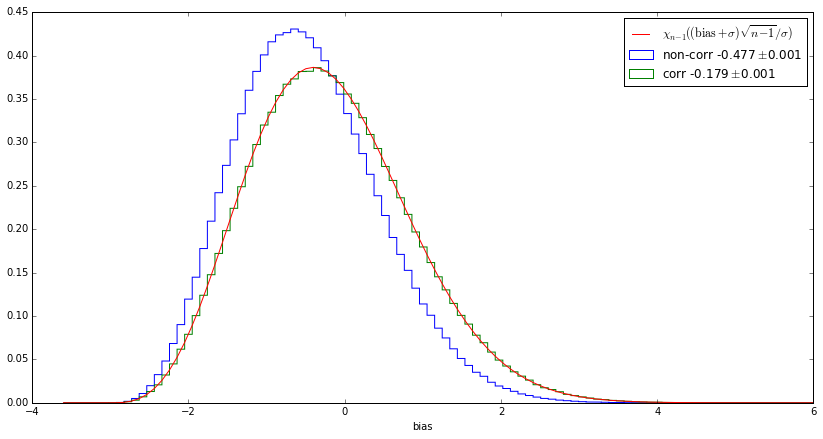

In [9]:
fig

<small>For a normal distribution $y^2\sim\chi^2_{n-1}$ with $y=\sqrt{n-1}s/\sigma$ by [Cochran's theorem](https://en.wikipedia.org/wiki/Cochran%27s_theorem), so in principle it is possibile to have an analytical expression for an unbiased estimator</small>

Can we draw a conclusions from these numbers? (answer=yes, detail in the rest of the lecture)

   * <strong>Statistic</strong>: a function of the data
   * <strong>Conditional probability</strong> $P(A|B) = P(A\cap B) / P(B)$
      - 2% $\stackrel{?}{=}$ P(to be pregnant|to be woman) $\neq$ P(to be woman|to be pregnant) = 1
   * <strong>Bayes theorem</strong> $P(A|B)P(B) = P(B|A)P(A)$
   * <strong>Likelihood</strong>: $\mathcal{L}(\theta|\text{data}) = P(\text{data}|\theta)$

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


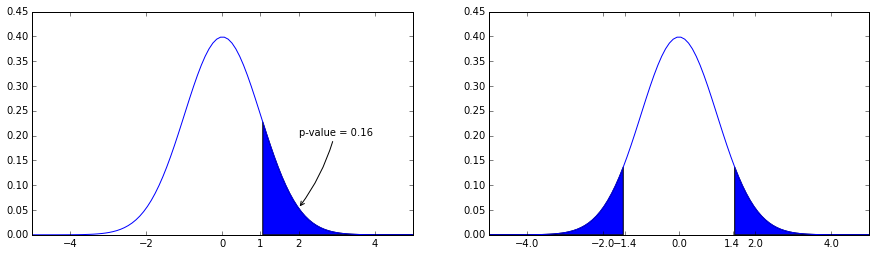

In [10]:
fig_gaussian, axs = plt.subplots(1, 2, figsize=(15, 4))
x = np.linspace(-5, 5, 100)
norm = stats.norm
y = norm.pdf(x)
z = 1.
mask = x > z
for ax in axs.flat:
    ax.plot(x, y)
axs[0].fill_between(x[mask], y[mask])
pvalue = norm.sf(z)
axs[0].annotate("p-value = %.2f" % pvalue, xy=(2, norm.pdf(2)), xytext=(z*2, 0.2), ha='left', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1", facecolor='black'))
axs[0].set_xticks(list(axs[0].get_xticks()) + [z])

z = norm.isf(pvalue / 2.)
axs[1].fill_between(x[x>z], y[x>z])
axs[1].fill_between(x[x<-z], y[x<-z])
axs[1].set_xticks(list(axs[1].get_xticks()) + [z, -z])

for ax in axs.flat:
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 0.45)

plt.show()


## Normal significance

Usually p-values are translated in a more-friendly normal-significance (number of sigmas) $z$. With the one-tail definition this is the value (quantile) corresponding to a certain p-value for a standard gaussian:

$$ \int_z^\infty N[x| 0, 1] dx = \text{p-value}$$

or $ \int_z^\infty + \int_{-\infty}^{-z} N[x|0,1] dx = \text{p-value}$ for the two-tail definition.

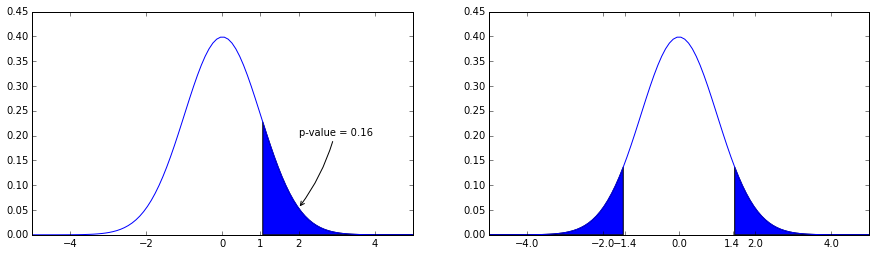

In [11]:
fig_gaussian

$$ \int_z^\infty N[x| 0, 1] dx = \text{p-value}$$

Taking into account the definition of the cumulative density function of a normal distribution, $\Phi(z) = \int_{-\infty}^{z} N[x| 0, 1] dx$, this can be written as:

$$ z = \Phi^{-1}(1 - \text{p-value})$$

or taking into account the definition of the survival function $SF(z) = 1 - CDF(z)$:

$$ z = \text{SF}^{-1}(\text{p-value})$$

In [12]:
def get_significance(p_value, onetail=True):
    if not onetail:
        p_value /= 2
    return stats.norm.isf(p_value)  # inverse of the survival function

In [140]:
table = '<table float="left"><tr><td>p-value</td><td>z (one tail)</td><td>z (two tails)</td></tr>'
for p_value in np.logspace(-1, -8, 8):
    table += "<tr><td>%.5g</td><td>%.3f</td><td>%.3f</td></tr>" % (p_value, get_significance(p_value), get_significance(p_value, False))
table += "</table>"

table += '<table float="left"><tr><td>z (one tail)</td><td>p-value</td></tr>'
for z in np.arange(1, 7):
    pvalue = stats.norm.sf(z)
    table += "<tr><td>%.2f</td><td>%.2g</td></tr>" % (z, pvalue)
table += "</table>"    

In [141]:
HTML(table)

In HEP usually we call "evidence" deviation at $3\sigma$ ($z=3$) and "discovery" at $5\sigma$. In other field much bigger p-values (smaller significance) are used.

Counting model: observed events $N_{obs}$ distributed as Poisson distribution. Observed events can be signal or background. We know the prediction (expected) for the background: $N_{bkg}^{exp}$. 

Question: is there a signal? Compute the p-value.
   * null hypothesis = background-only (expected signal = 0)
   * Observable: $N_{obs}$
   * Statistics: $N_{obs}$

$P(N_{obs} | \text{no signal}) = \text{Poisson}[N_{obs}|N_{bkg}^{exp}]$. 

$$\text{p-value} = \int_{N_{obs}}^{\infty} P(N_{obs}|\text{no signal})$$

p-value: 0.072160  z: 1.46  s/sqrt(b): 1.41


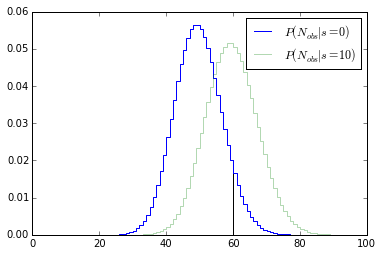

In [15]:
@interact(NBKG_EXP=(1, 100), NOBS=(1, 100), NSIG_EXP=(0, 20))
def simple_example_poisson(NBKG_EXP=50, NOBS=60, NSIG_EXP=10):
    pdf_b = stats.poisson(NBKG_EXP)
    p_value = pdf_b.sf(NOBS)
    print "p-value: {:f}  z: {:.2f}  s/sqrt(b): {:.2f}".format(p_value, get_significance(p_value), (NOBS - NBKG_EXP) / np.sqrt(NBKG_EXP))
    
    #plot
    x = np.arange(0, NBKG_EXP * 2)
    y = pdf_b.pmf(x)
    plt.plot(x, y, linestyle='steps', label='$P(N_{obs}|s=0)$')
    plt.plot(x, stats.poisson(NBKG_EXP + NSIG_EXP).pmf(x), linestyle='steps', alpha=0.3, label='$P(N_{obs}|s=%d)$' % NSIG_EXP)
    #plt.step(x, y, fillcolor='red')
    #plt.fill_between(x, y, steps='pre')
    plt.vlines(NOBS, 0, pdf_b.pmf(NOBS))
    plt.legend(loc=0)

<small>
   * Note that exclusing the null-hypothesis doesn't mean that we consider the alternative hypothesis true.   
   * Note that what we have computed is $P(N_{obs} | \text{no signal})$, which can be written more generally as $P(\text{data}|\text{model})$, so we are computing a probability about data.
   * We are not computing a probability about the model ($P(\text{model})$, which is what we want to know!)
   * Remember the definition of probability in the frequenstis approach $P(E) = \lim_{N\to\infty}\frac{n}{N}$, where $n$ is the number of occurrences of an event $E$ in $N$ trials. This can only be applied to repeatable events
   * Only in a Bayesian framework you can aswer (or compute the relative probability) questions like "Is there the Higgs boson?", "Will it rain tomorrow?", "Was Napoleon murdered?"
   
> "Bayesians address the question everyone is interested in, by using
> assumptions no-one believes"

> "Frequentists use impeccable logic to deal with an issue of no interest to
>anyone"
L. Lyons
</small>
  

   

In [16]:
def eval_sensitivity(signal_efficiency=0.8, bkg_rejection=10):
    bkg_xsec = 1000.; signal_xsec_exp = 1.
    luminosities = np.linspace(0., 200., 200)

    pvalues, zs = [], []
    for lumi in luminosities:
        nsignal_exp = lumi * signal_xsec_exp * signal_efficiency
        nbkg_exp = lumi * bkg_xsec / bkg_rejection
        p_value = stats.poisson.sf(nsignal_exp + nbkg_exp, nbkg_exp)
        pvalues.append(p_value)
        zs.append(get_significance(p_value))

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(luminosities, zs)
    axs[0].set_ylim(0, 6); axs[1].set_ylim(0.001, 0.3)
    axs[1].semilogy(luminosities, pvalues)
    
    for ax in axs.flat:
        ax.set_xlabel('luminosity')

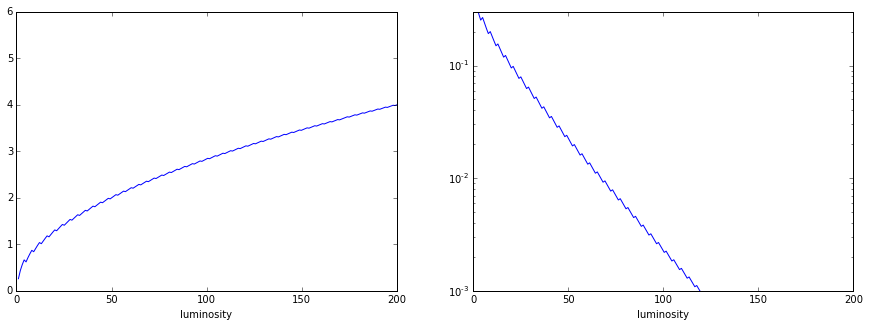

In [19]:
eval_sensitivity = interact(eval_sensitivity, signal_efficiency=(0.7, 1, 0.01), bkg_rejection=(3, 500, 10))

In [18]:
ws = ROOT.RooWorkspace('ws')
nbkg_exp = ws.factory("nbkg_exp[1000]")
n_exp = ws.factory("sum::n_exp(nsig_exp[100], nbkg_exp)")
pdf = ws.factory("Poisson::signal(n_obs[0, 10000], n_exp)")
aset = ROOT.RooArgSet(ws.var('n_obs'))
data = pdf.generate(aset, 1)
n_obs_val = data.get(0).first().getVal()

NameError: name 'ROOT' is not defined

We expect to observe $s+b =$ {{ws.var('nsig_exp').getVal()}} + {{ws.var('nbkg_exp').getVal()}} = {{n_exp.getVal()}} events if there is a signal and {{ws.var('nbkg_exp').getVal()}} if there is only background. We observe {{n_obs_val}}. Is there a signal?

As first step compute the significance as $s / \sqrt{b}$

In [ ]:
(n_obs_val - nbkg_exp.getVal()) / np.sqrt(nbkg_exp.getVal())

In [135]:
from sympy.stats import Poisson, Normal, density, E, variance, cdf
from sympy import Symbol, simplify, series, exp
from sympy import mpmath
sluminosity = Symbol("sL", positive=True)
luminosity = sluminosity ** 2
#s = Symbol('s', positive=True)
#b = Symbol('b', positive=True)
signal = luminosity
bkg = luminosity
rate = bkg
k = Symbol('k')
poisson_pdf = exp(-rate) * rate ** k
pvalue = simplify(1 - cdf(X)(bkg+signal))
z = Symbol("z", positive=True)
G = Normal(z, 0, 1)
from sympy.solvers import solve
z = simplify(solve(1 - cdf(G)(z) - pvalue, z)[0])
z

sqrt(2)*erfinv(1 - 2*lowergamma(2*sL**2 + 1, sL**2)/factorial(2*sL**2))

In [127]:
x = Symbol('x')
density(X)(x)

sL**(2*x)*exp(-sL**2)/factorial(x)

KeyboardInterrupt: 

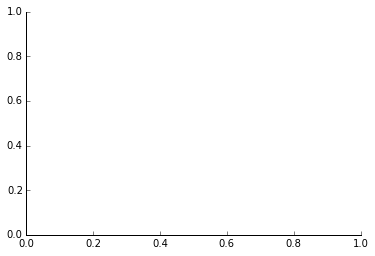

In [119]:
plot(z, (sluminosity, 1, 100))

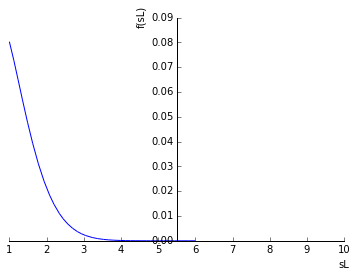

In [121]:
from sympy.plotting import plot
plot(pvalue, (sluminosity, 1, 10))